# Home Assignment No. 2: Practice

To solve this task efficiently, here are some practical suggestions:

* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember to use tutorials, lecture slides, and other resources.


* Instead of rewriting existing code try to use **BUILT-IN METHODS** available in the libraries.


* To complete this part of the homework, you have to write some **CODE** directly inside the specified places in the notebook **CELLS**.


* In some problems you are asked to provide a short discussion of the results. In these cases you have to create a **MARKDOWN** cell with your comments right after the corresponding code cell.


* For every separate problem, you can get **INTERMEDIATE scores**.


* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if a reviewer executes your code, the output will be the same (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.


* Your code must be readable. For this purpose, try to include **necessary** (and not more) comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY**.


* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameter and set it to `-1` to use all the cores.


* In the end you need to hand in a **single zip file** containing **two notebooks** (theory and practice) as well as the **html exported version** of this notebook (**4 files in total**).


To begin let's import the essential (for this assignment) libraries.

In [3]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time

# Set default parameters for plots
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Part 1: Linear SVM (face detection)

In this part you will need to implement a linear SVM classifier via the gradient descent algorithm.

First, let us have a look at the data we want to train our algorithm on.

In [4]:
# Load the faces data
data = loadmat('faces.mat')
labels = np.squeeze(data['Labels'])
data = data['Data']

Let us visualize some examples from the dataset. The dataset contains a set of $24 \times 24$ grayscale images labeled as face/non-face. Our goal is to train a classifier on this data. For calculations we will treat the samples as flattened vectors, the same way as they are stored. For visualization one needs to reshape the samples to $24 \times 24$ images.

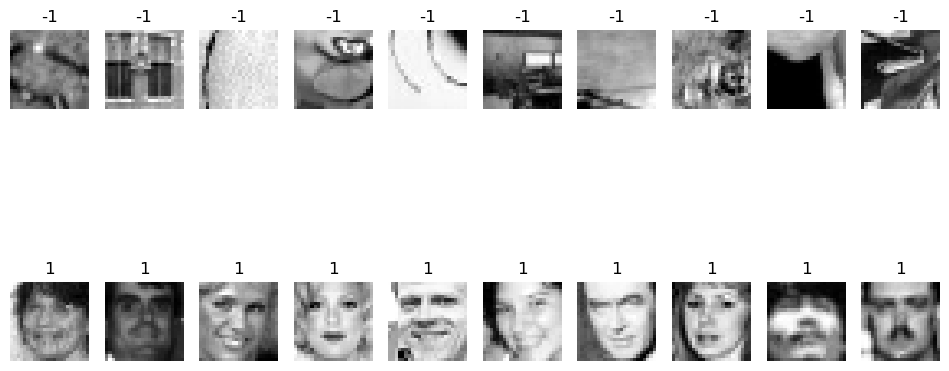

In [5]:
# Visualize some examples from the dataset.
samples_per_class = 10
classes = [-1, 1]
train_imgs = np.reshape(data, [-1, 24, 24], order='F')

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(np.equal(labels, cls))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = y * samples_per_class + i + 1
        plt.subplot(len(classes), samples_per_class, plt_idx)
        plt.imshow(train_imgs[idx])
        plt.axis('off')
        plt.title(cls)
plt.show()

## Task 1.1: SVM loss function [6 points]

In the lectures we have seen the SMO algorithm, which works in the dual domain. In this assignment we explore **Pegasos**, an optimization algorithm in the primal domain.

Recall the formulation of the SVM optimization problem as follows:

\begin{aligned}
& \min_{w, b}
& & \frac{1}{2}||w||^2 + C\sum_{i=1}^m \xi_i \\
& \ \text{ s.t.}
& & y^{(i)}(w^Tx^{(i)}+b) \geq 1-\xi_i, \; i = 1, \ldots, m \\
& & & \xi_i \geq 0, \; i = 1, \ldots, m \\
\end{aligned}

Let $f(x)=w^Tx+b$. The constraints can then be written as $y^{(i)}f(x^{(i)})\geq 1-\xi_i$. Together with the constraints $\xi_i \geq 0$ this leads to $\xi_i=\max(0, 1-y^{(i)}f(x^{(i)}))$. The above constraint optimization problem is therefore equivalent to the following **unconstrained** problem:

$$
\min_{w, b} \frac{\lambda}{2}||w||^2 + \frac{1}{m}\sum_{i=1}^m \max(0, 1-y^{(i)}f(x^{(i)})).
$$

The first term in this objective is a regularization term (prevents overfitting) and the second term measures the classification loss. Here the parameter $\lambda=1/C$ is a **hyper-parameter** that controls the relative weight of  both losses.


**TODO**: Implement the **unconstrained** objective function for SVM in the following *svm_loss* function according to the specifications.

***HINT***: Write a small test for the provided values of w, b and C. Make sure your function passes the test.

In [6]:
def svm_loss(w, b, X, y, lambda_):
    """
    Computes the loss of a linear SVM w.r.t. the given data and parameters.

    Args:
        w: Parameters of shape [num_features]
        b: Bias (a scalar)
        X: Data matrix of shape [num_data, num_features]
        y: Labels corresponding to X of size [num_data, 1]
        lambda_: Regularization hyper-parameter

    Returns:
        l: The value of the objective for a linear SVM

    """
    # Compute function f(x), vector of num_data rows
    fx = X @ w + b

    # Compute maxima, vector of num_data rows
    maxima = np.maximum(np.zeros_like(fx), np.ones_like(fx) - y*fx)

    # Compute first term
    t1 = lambda_*np.sum(np.square(w))

    # Compute second term
    t2 = np.mean(maxima)

    # Return loss
    return t1 + t2

In [7]:
# Test the cost-function
w_0 = np.zeros(data.shape[1])
b_0 = 0.
l_0 = svm_loss(w_0, b_0, data, labels, 1.)

# Expected output for loss for above parameters
expected_output = 1

# Print, if test was successful
assert np.allclose(l_0, expected_output), "Something is wrong"
print("Well done!")

Well done!


## Task 1.2: SVM gradient [9 points]

**TODO**: Implement the gradient of the above unconstrained objective w.r.t. to the parameters $w$ and $b$. The gradient will be computed on a mini-batch (i.e., a random subset of the training set).

**Hint**: Don't worry about the fact that $\max(0, 1-y^{(i)}f(x^{(i)}))$ is not differentiable at $1-y^{(i)}f(x^{(i)})=0$. Just pick a one-sided gradient (this is called a subgradient for convex functions).

Note, that the sum $\sum_{i=1}^m \max[0, 1-f(x^{(i)})]$ can also be written as
$$
\sum_{i=1}^m \max[0, 1-f(x^{(i)})] = \sum_{i:f(x^{(i)})<1}\left[1-f(x^{(i)})\right].
$$
Hence, the loss function to be minimized is given by
$$
\mathcal{L}(w,b) = \frac{\lambda}{2}||w||^2 + \sum_{i:f(x^{(i)})<1}\left[1-f(x^{(i)})\right], \qquad f(x^{(i)}) = y^{(i)}\left(w^\top x^{(i)} + b\right).
$$
Therefore, the gradients $\nabla_w$ and $\nabla_b$ of $\mathcal{L}(w,b)$ are given by
\begin{align*}
\nabla_w \mathcal{L}(w,b) = \lambda w - \frac{1}{m}\sum_{i:f(x^{(i)})<1}y^{(i)}x^{(i)}, \qquad \nabla_b \mathcal{L}(w,b) = -\frac{1}{m}\sum_{i:f(x^{(i)})<1}y^{(i)}.
\end{align*}

In [8]:
def svm_gradient(w, b, x, y, lambda_):
    """
    Compute gradient for SVM w.r.t. to the parameters w and b on a mini-batch (x, y).

    Args:
        w: Parameters of shape [num_features]
        b: Bias (a scalar)
        x: A mini-batch of training example [k, num_features]
        y: Labels corresponding to x of size [k]
        lambda_: Regularization hyper-parameter

    Returns:
        grad_w: The gradient of the SVM objective w.r.t. w of shape [num_features]
        grad_v: The gradient of the SVM objective w.r.t. b of shape [1]

    """
    # Compute condition
    cond = y*(x @ w + b)

    # Create mask
    mask = (cond < 1).astype(int)

    # Calculate gradients
    grad_w = lambda_*w - (1/x.shape[0])*np.sum(y[:, np.newaxis]*mask[:, np.newaxis]*x, axis=0)
    grad_b = - (1/x.shape[0])*np.sum(y*mask)

    # Return gradients
    return grad_w, grad_b

In [9]:
# Test the implementation
x_ = np.ones([2, 10])
y_ = np.array([1, -1])
w_0 = np.zeros(10)
b_0 = 0.
grad_w, grad_b = svm_gradient(w_0, b_0, x_, y_, 1.)

# Calculate expected gradients with above parameters
expected_grad_w = 0
expected_grad_b = 0

# Print, if test was successful
assert np.allclose(grad_w, expected_grad_w), "Something is wrong"
assert np.allclose(grad_b, expected_grad_b), "Something is wrong"
print("Well done!")

Well done!


## Task 1.3: SVM Solver [18 points]

You will implement the **Pegasos** algorithm - a variant of SGD - to solve for the parameters $w$ and $b$. 

The algorithm was introduced in the following [Paper](http://ttic.uchicago.edu/~nati/Publications/PegasosMPB.pdf) (see Figure 2). It is essentially Stochastic Gradient Descent on mini-batches + a specific choice for the learning rate giving convergence guarantees. The required steps are outlined in the following class implementation. For more details, please refer to the [Paper](http://ttic.uchicago.edu/~nati/Publications/PegasosMPB.pdf).

**TODO**: Implement the Pegasos algorithm according to specs. Tune the hyper-parameter **C** to get at least 90% accuracy on test.

In [10]:
class LinearSVM:
    def __init__(self, lambda_):
        self.lambda_ = lambda_
        self.w = None
        self.b = None
        
    def fit(self, X, y, num_iter=30000, num_per_batch=100, verbose=False):
        """
        Pegasos SVM solver.

        Args:
            X: Data matrix of shape [num_train, num_features]
            y: Labels corresponding to X of size [num_train]
            num_iter: Number of iterations
            num_per_batch: Number of samples per mini-batch

        Returns:
            theta: The value of the parameters after training (saved to self.w and self.b)

        """
        # Initialize w and b
        self.w = np.zeros(X.shape[1])
        self.b = 0.

        # Perform stochastic gradient descent
        for t in range(1, num_iter):
            start = time.time()

            # Sample a random mini-batch
            batch_indices = np.random.choice(X.shape[0], size=num_per_batch, replace=False)
            batch_X = X[batch_indices]
            batch_y = y[batch_indices]

            # Compute learning rate
            n_t = 1/(self.lambda_*t)

            # Compute gradients
            g_w, g_b = svm_gradient(self.w, self.b, batch_X, batch_y, self.lambda_)

            # Update parameters
            self.w, self.b = self.w - n_t*g_w, self.b - n_t*g_b
            
            # Print progerss if verbose == True
            if verbose and t % 5000 == 0:
                exec_time = time.time() - start
                loss = svm_loss(self.w, self.b, X, y, self.lambda_)
                print(f'Iter {t}/{num_iter}: cost = {loss}  ({exec_time}s)')

    def predict_score(self, X):
        """
        Predicts a score for each sample (how confident the prediction is).
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            
        Returns:
            Predictions of shape [num_train] (real numbers)

        """
        # Compute w^T x + b for every sample in the data matrix X
        preds = X @ self.w + self.b

        # Return scores for each sample in X
        return preds                
                
    def predict(self, X):
        """
        Predicts class labels on X.
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            
        Returns:
            Predictions of shape [num_train]

        """
        # Calculate prediction scores
        pred_scores = self.predict_score(X)

        # Compute label predictions
        preds = np.where(pred_scores > 0, 1, -1)

        # Return predicted class labels
        return preds
    
    def score(self, X, y):
        """
        Calculates accuracy of the model on X.
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            y: Labels corresponding to X of size [num_train]
            
        Returns:
            Model's accuracy score.
        """
        # Compute predicted class labels
        y_pred = self.predict(X)

        # Calculate number of correct predictions
        correct_pred = np.sum(y_pred == y)

        # Compute score
        score = correct_pred/y.shape[0]
        
        # Return accuracy calculated as number of correct labels in y_pred divided by total number of labels in y_pred
        return score

Now we are going to train the model. First let's split the data into train and test sets and normalize them.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3)

In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [13]:
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (13882, 576)
Training labels shape:  (13882,)
Test data shape:  (5950, 576)
Test labels shape:  (5950,)


Now let us create a classifier instance and **fit** in on the training data.

In [14]:
# We will measure the execution time
start = time.time()

C = 1.0
lambda_ = 1/C
my_svm = LinearSVM(lambda_=lambda_)
my_svm.fit(X_train, y_train, num_iter=30000, num_per_batch=64, verbose=True)

exec_time = time.time()-start
print('Total exection time: {}s'.format(exec_time))

Iter 5000/30000: cost = 0.4369531002316598  (0.0009882450103759766s)
Iter 10000/30000: cost = 0.4364743505398553  (0.0s)
Iter 15000/30000: cost = 0.43634957899929017  (0.0s)
Iter 20000/30000: cost = 0.4364116198730744  (0.0009603500366210938s)
Iter 25000/30000: cost = 0.43605083984122117  (0.0s)
Total exection time: 15.896063089370728s


 We can have a look at what theta has learned to recognise as "face"

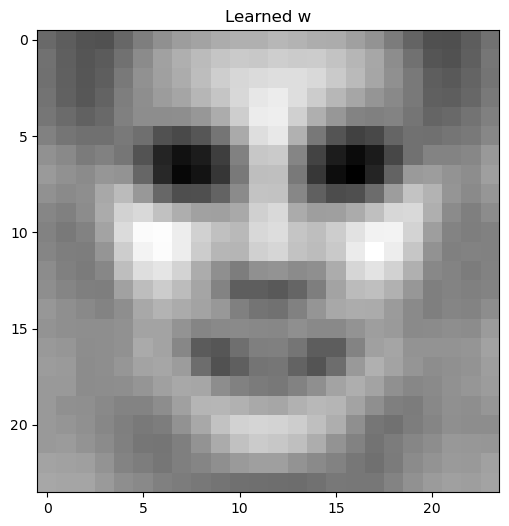

In [15]:
plt.imshow(np.reshape(my_svm.w, [24, 24], order='F'))
plt.title('Learned w')
plt.show()

Predicted label:  -1
True label:  -1


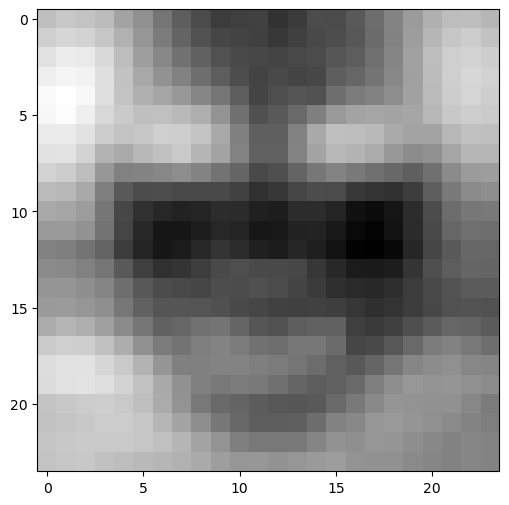

In [16]:
# Test an individual sample
idx = 1
print('Predicted label: ', my_svm.predict(X_test[idx]))
print('True label: ', y_test[idx])
plt.imshow(np.reshape(X_test[idx], [24, 24], order='F'))
plt.show()

Make the predictions, calculate the accuracy. Tune the hyperparameter C to get at least **90%** accuracy on the test!

In [17]:
print('Found C = {}, lambda = {}'.format(C, lambda_))
print('Accuracy train: {}'.format(my_svm.score(X_train, y_train)))
print('Accuracy test: {}'.format(my_svm.score(X_test, y_test)))

Found C = 1.0, lambda = 1.0
Accuracy train: 0.9112519809825673
Accuracy test: 0.9119327731092437


## Part 2: Multiclass classification

## Task 2.1: ONE-VS-ALL SVM [12 points]

SVM is designed to solve a binary classification problem. What if we want to solve _multiclass classification_, meaning that we want to classify sample in 1 to K labels (with K>2)?

We can still use binary SVM to solve this problem in a _one-vs-all_ manner, meaning that we can train _K_ binary classifiers distinguishing class $k$ vs the rest of the classes.

You will implement multiclass classification using your LinearSVM implementation as follows:
1. Initialize MulticlassLinearSVM with _K_ LinearSVMs
2. For each _k=1..K_ labels:  
    a. Convert multiclass labels into binary labels: _y==1_ if _target==k_, _y==-1_ if _target!=k_  
    b. Train a binary classifier with this labels
3. To predict a label for an unknown sample:  
    a. Get a prediction score for each binary classifier  
    b. Return the label for which the score is the highest

**TODO**: Implement the multiclass SVM.

In [18]:
class MulticlassLinearSVM:
    def __init__(self, lambda_, K_classes):
        self.lambda_ = lambda_
        self.K_classes = K_classes
        self.classifiers = [LinearSVM(lambda_=lambda_) for i in range(0, K_classes)]
        
        
    def fit(self, X, y, num_iter=30000, num_per_batch=100, verbose=False):
        """
        Fit K classifiers.

        Args:
            X: Data matrix of shape [num_train, num_features]
            y: Labels corresponding to X of size [num_train]; values from 0..K_classes-1
            num_iter: Number of iterations
            num_per_batch: Number of samples per mini-batch

        """
        # Loop over classes
        for k in range(0, self.K_classes):
            start = time.time()
            
            # Get current SVM classifier
            current_classifier = self.classifiers[k]

            # Convert labels y to binary labels
            y_bin = np.array([1 if cl == k else -1 for cl in y])

            # Initialize w and b of current classifier
            current_classifier.w = np.zeros(X.shape[1])
            current_classifier.b = 0.

            # Perform stochastic gradient descent
            for t in range(1, num_iter):
                # Sample random mini-batch
                batch_indices = np.random.choice(X.shape[0], size=num_per_batch, replace=False)
                batch_X = X[batch_indices]
                batch_y = y_bin[batch_indices]

                # Compute learning rate
                n_t = 1/(self.lambda_*t)

                # Compute gradients
                g_w, g_b = svm_gradient(current_classifier.w, current_classifier.b, batch_X, batch_y, self.lambda_)

                # Update parameters
                current_classifier.w, current_classifier.b = current_classifier.w - n_t*g_w, current_classifier.b - n_t*g_b

                # Print progress if verbose == True
                if verbose and t % 1000 == 0:
                    loss = svm_loss(current_classifier.w, current_classifier.b, X, y_bin, self.lambda_)
                    exec_time = time.time() - start
                    print(f'Iter {t}/{num_iter}: cost = {loss}  ({exec_time}s)')
            
            # Print execution time
            exec_time = time.time() - start
            print(f'Classifier {k+1}/{self.K_classes}: time ({exec_time}s)')
    
    def predict(self, X):
        """
        Predicts class labels on X.
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            
        Returns:
            Predictions of shape [num_train] in {0..K_classes-1}
        """
        # Define array to store predicted scores
        pred_scores = np.zeros(shape=(X.shape[0], self.K_classes))

        # Predict binary class labels for each classifier
        for k in range(0, self.K_classes):
            pred_scores[:, k] = X @ self.classifiers[k].w + self.classifiers[k].b

        # Assign class label with highest score for each sample in X
        preds = np.array([np.argmax(row) for row in pred_scores])

        # Return class labels
        return preds
    
    def score(self, X, y):
        """
        Calculates accuracy of the model on X.
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            y: Labels corresponding to X of size [num_train]
            
        Returns:
            Model's accuracy score.
        """
        # Compute predicted class labels
        y_pred = self.predict(X)

        # Calculate number of correct predictions
        correct_pred = np.sum(y_pred == y)

        # Compute score
        score = correct_pred/y.shape[0]

        # Return accuracy as number of correct labels in y_pred divided by total number of labels in y_pred
        return score

### Simple (non-exhaustive) test
The code below should execute without errors and give ~25% accuracy

In [19]:
# We will measure the execution time
start = time.time()

C = 10.0
lambda_ = 1/C

n_classes = 4
n_samples = 2000
data_random = np.random.randn(n_samples, 2)
labels_random = np.array([np.random.randint(n_classes) for i in range(n_samples)])

mc_svm = MulticlassLinearSVM(lambda_=lambda_, K_classes=n_classes)
mc_svm.fit(data_random, labels_random, num_iter=1000, num_per_batch=64, verbose=True)

pred = mc_svm.predict(data_random)
print('Accuracy: ', mc_svm.score(data_random, labels_random))

exec_time = time.time()-start
print('Total execution time: {}s'.format(exec_time))

Classifier 1/4: time (0.07015132904052734s)
Classifier 2/4: time (0.06364059448242188s)
Classifier 3/4: time (0.06269359588623047s)
Classifier 4/4: time (0.06470823287963867s)
Accuracy:  0.2555
Total execution time: 0.27014780044555664s


## Classification on FashionMNIST dataset
We'll train a multiclass SVM on FashionMNIST dataset, containing $28\times28$ grayscale images of 10 categories of clothing.  
Let's load and visualize the dataset

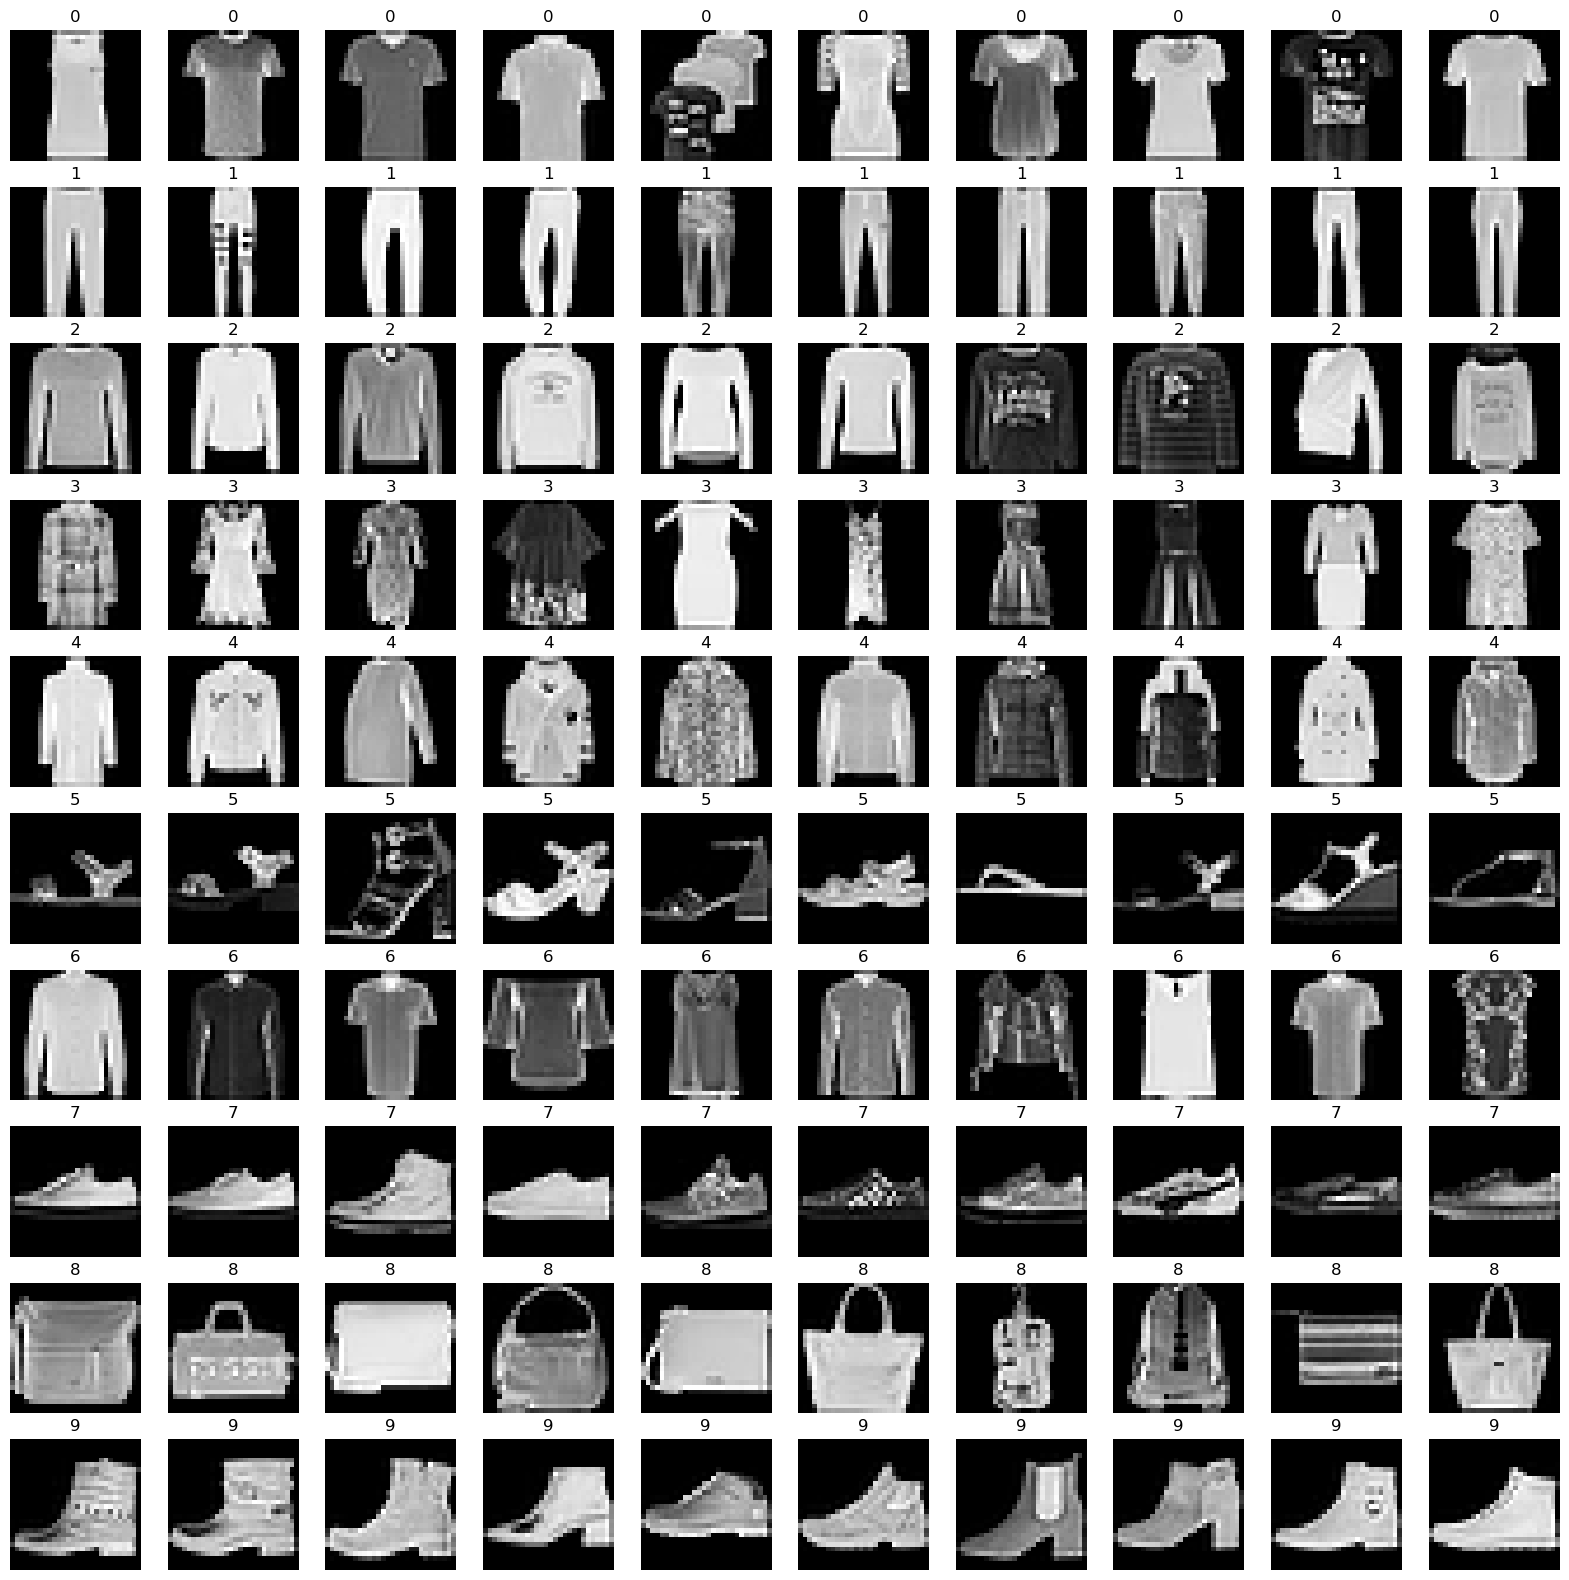

In [20]:
fmnist_data = np.load('fashion_mnist.npz')
X_train, X_test, y_train, y_test = fmnist_data['x_train'], fmnist_data['x_test'], fmnist_data['y_train'], fmnist_data['y_test']

# Visualize some examples from the dataset.
samples_per_class = 10
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_imgs = np.reshape(X_train, [-1, 28, 28], order='F')

plt.figure(figsize=(20,20))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(np.equal(y_train, cls))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = y * samples_per_class + i + 1
        plt.subplot(len(classes), samples_per_class, plt_idx)
        plt.imshow(train_imgs[idx])
        plt.axis('off')
        plt.title(cls)
plt.show()

Now let's normalize the data, train the model and visualize the weights for each classifier

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
C = 0.01
lambda_ = 1./C
my_svm = MulticlassLinearSVM(lambda_=lambda_, K_classes=10)

my_svm.fit(X_train_scaled, y_train, num_iter=10000, num_per_batch=64, verbose=True)

exec_time = time.time()-start
print('Total exection time: {}s'.format(exec_time))

Iter 1000/10000: cost = 0.9540806774122432  (0.8282315731048584s)
Iter 2000/10000: cost = 0.9488027396733296  (1.7063932418823242s)
Iter 3000/10000: cost = 0.9456596257782871  (2.490626096725464s)
Iter 4000/10000: cost = 0.943869848713286  (3.2823646068573s)
Iter 5000/10000: cost = 0.9424378443051225  (4.116831302642822s)
Iter 6000/10000: cost = 0.9414061169255574  (4.893781661987305s)
Iter 7000/10000: cost = 0.940363696562629  (5.717608451843262s)
Iter 8000/10000: cost = 0.9396122373233324  (6.560165882110596s)
Iter 9000/10000: cost = 0.939008492794832  (7.334057807922363s)
Classifier 1/10: time (8.135059356689453s)
Iter 1000/10000: cost = 0.9532086941872537  (0.8731024265289307s)
Iter 2000/10000: cost = 0.9507705715282089  (1.7286720275878906s)
Iter 3000/10000: cost = 0.9481698460471327  (2.887655019760132s)
Iter 4000/10000: cost = 0.9457436487905027  (3.8518261909484863s)
Iter 5000/10000: cost = 0.9442339552937664  (4.784603595733643s)
Iter 6000/10000: cost = 0.9428247388789751  (5.

In [23]:
print('C = {}, lambda = {}'.format(C, lambda_))
print('Accuracy train: {}'.format(my_svm.score(X_train_scaled, y_train)))
print('Accuracy test: {}'.format(my_svm.score(X_test_scaled, y_test)))

C = 0.01, lambda = 100.0
Accuracy train: 0.6417916666666666
Accuracy test: 0.643


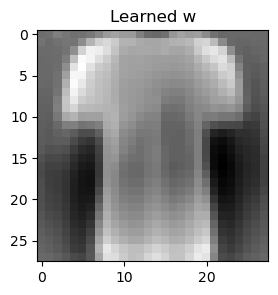

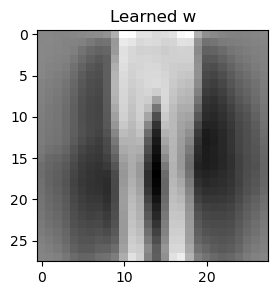

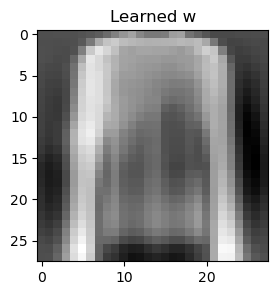

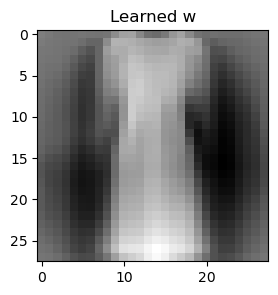

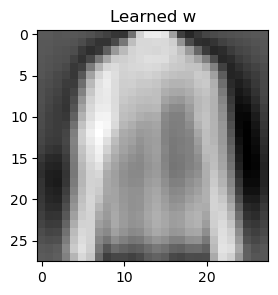

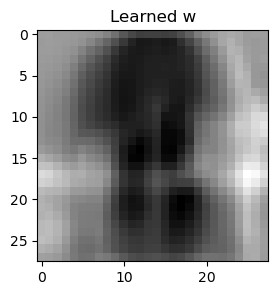

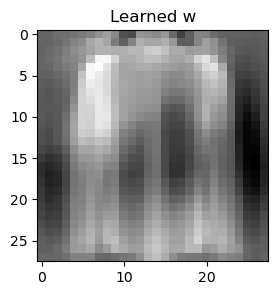

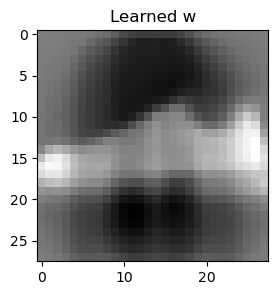

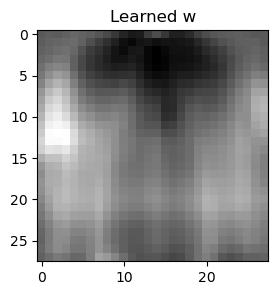

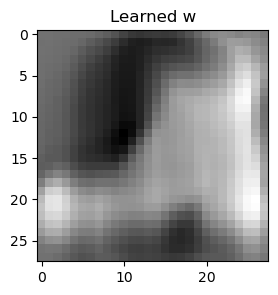

In [24]:
for classifier in my_svm.classifiers:
    plt.figure(figsize=(3,3))
    plt.imshow(np.reshape(classifier.w, [28, 28], order='F'))
    plt.title('Learned w')
    plt.show()

**TODO:** Tune the parameter **C** to get at least **80%** test accuracy

In [25]:
C = 1.6
lambda_ = 1./C
my_svm = MulticlassLinearSVM(lambda_=lambda_, K_classes=10)

my_svm.fit(X_train_scaled, y_train, num_iter=10000, num_per_batch=64, verbose=True)

exec_time = time.time()-start
print('Total exection time: {}s'.format(exec_time))

Iter 1000/10000: cost = 0.14864325927847868  (0.8161592483520508s)
Iter 2000/10000: cost = 0.14738794769640517  (1.6230440139770508s)
Iter 3000/10000: cost = 0.1474678918392431  (2.4364817142486572s)
Iter 4000/10000: cost = 0.14667308499237897  (3.24981689453125s)
Iter 5000/10000: cost = 0.14628206190537202  (4.051953077316284s)
Iter 6000/10000: cost = 0.1460637213671979  (4.88463568687439s)
Iter 7000/10000: cost = 0.14590675240069775  (5.76668119430542s)
Iter 8000/10000: cost = 0.14578725017830768  (6.577742099761963s)
Iter 9000/10000: cost = 0.14600572706266166  (7.418274164199829s)
Classifier 1/10: time (8.160902738571167s)
Iter 1000/10000: cost = 0.06896679076634366  (0.7711760997772217s)
Iter 2000/10000: cost = 0.06885935612968173  (1.585538625717163s)
Iter 3000/10000: cost = 0.06840417808252264  (2.395681142807007s)
Iter 4000/10000: cost = 0.0685879817897599  (3.2714598178863525s)
Iter 5000/10000: cost = 0.06811532642034147  (4.108520746231079s)
Iter 6000/10000: cost = 0.06799488

In [26]:
print('Found C = {}, lambda = {}'.format(C, lambda_))
print('Accuracy train: {}'.format(my_svm.score(X_train_scaled, y_train)))
print('Accuracy test: {}'.format(my_svm.score(X_test_scaled, y_test)))

Found C = 1.6, lambda = 0.625
Accuracy train: 0.80775
Accuracy test: 0.8004166666666667


## Part 3: SVM with RBF kernel

## Task 3.1: Compare RBF and linear kernels [10 points]

**TODO:** Compare SVM with linear and RBF kernels on toy datasets. Implement *plot_classifiers_predictions* function. Make sure to plot the decision regions as in the previous assignment as well as the support vectors.

**HINT:** You may use ideas from this [webpage](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-py).


In [27]:
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

In [28]:
def plot_classifiers_predictions(X, y, classifiers):
    """
    Plots the decision regions and support vectors of the classifiers
    fit on X and y.

    Args:
        X: Data matrix of shape [num_train, num_features]
        y: Labels of shape [num_train]
        classifiers: A list of classfifier objects

    """
    # Define figure
    fig, axes = plt.subplots(ncols=len(classifiers), nrows=1, figsize=(16, 8))

    # Iterate over classifier objects
    for classifier, axis in zip(classifiers, axes.flat):
        # Fit classifier to data
        classifier.fit(X, y)

        # Plot decision regions
        DecisionBoundaryDisplay.from_estimator(
            classifier,
            X,
            plot_method="contour",
            colors="k",
            levels=[-1, 0, 1],
            alpha=0.5,
            linestyles=["--", "-", "--"],
            ax=axis,
        )

        # plot support vectors
        axis.scatter(
            classifier.support_vectors_[:, 0],
            classifier.support_vectors_[:, 1],
            s=130,
            linewidth=1,
            facecolors="red",
            edgecolors="k",
        )

        # Plot all vectors
        axis.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Paired)
        
        # Set title and give score
        axis.set_title('{}, accuracy = {:.2f}'.format(
            classifier.__class__.__name__, classifier.score(X, y)))

In [29]:
from sklearn.svm import SVC

C = 1.0

linear_svc = SVC(kernel="linear", C=C)
rbf_svc = SVC(kernel="rbf", C=C)

classifiers = [linear_svc, rbf_svc]

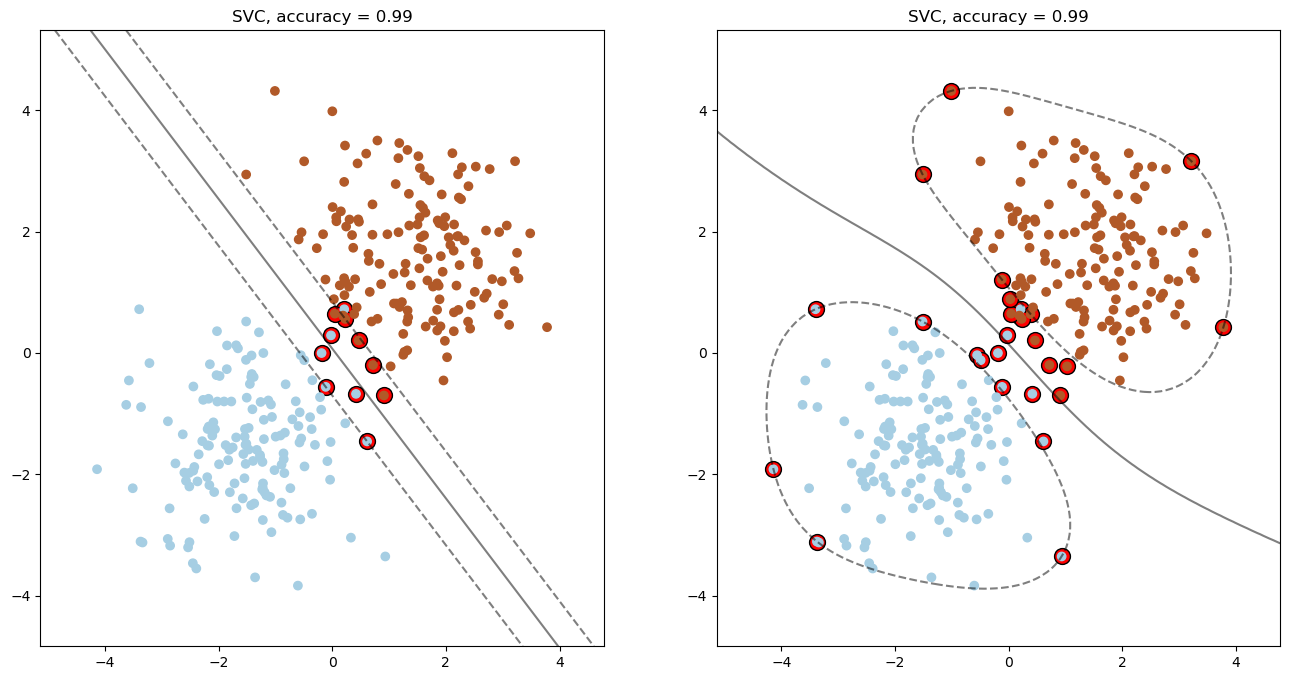

In [30]:
X_blobs, y_blobs = make_blobs(n_samples=300, centers=[[-1.5, -1.5], [1.5, 1.5]])
plot_classifiers_predictions(X_blobs, y_blobs, classifiers)

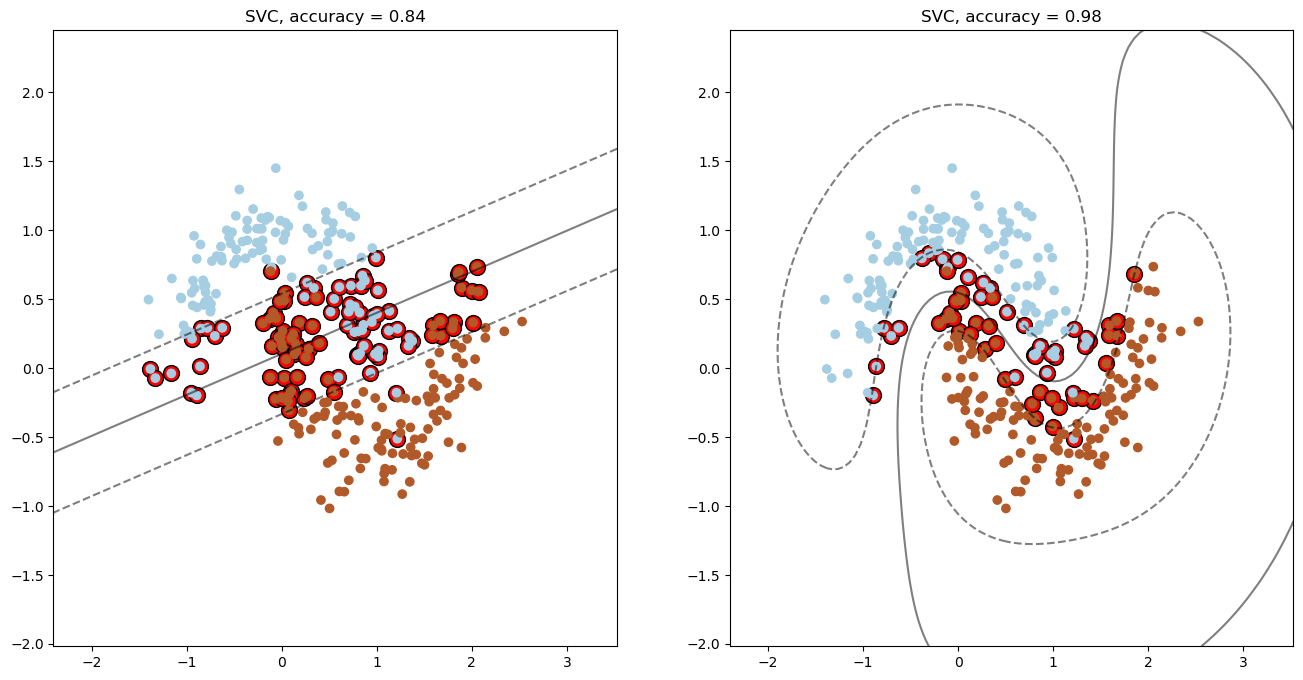

In [31]:
X_moons, y_moons = make_moons(n_samples=300, noise=0.2, random_state=0)
plot_classifiers_predictions(X_moons, y_moons, classifiers)

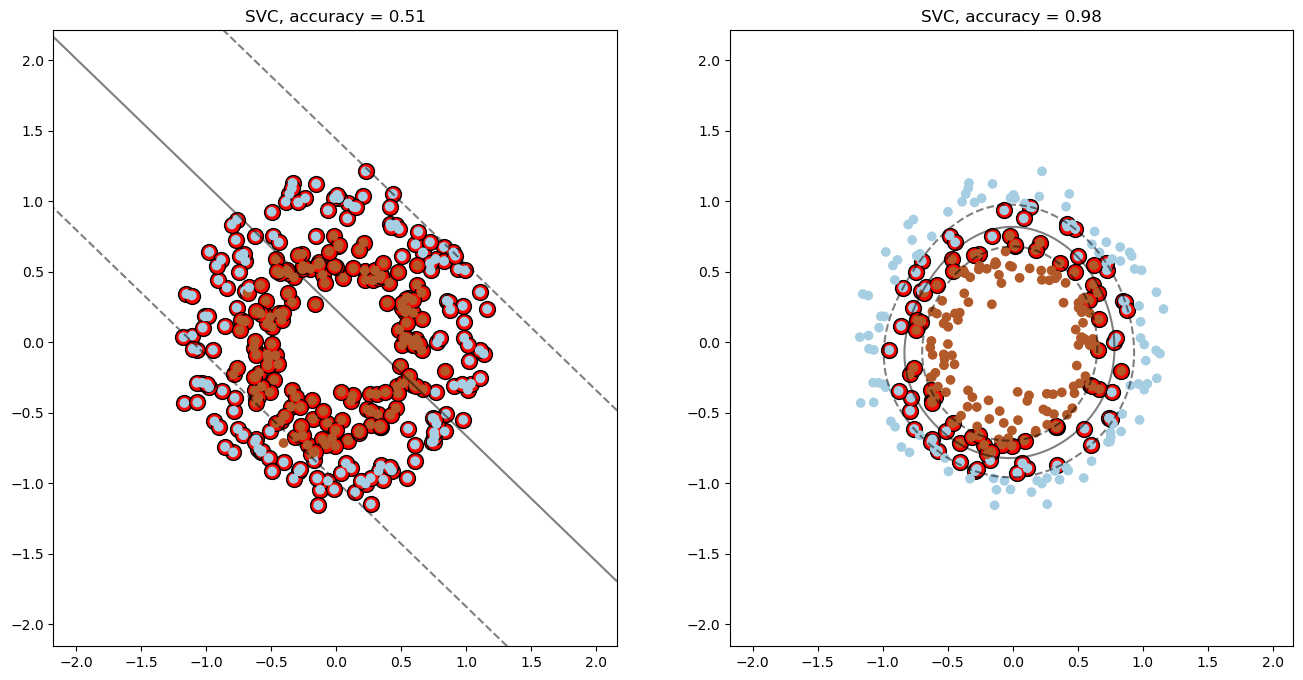

In [32]:
X_circles, y_circles = make_circles(n_samples=300, noise=0.1, random_state=0, factor=0.6)
plot_classifiers_predictions(X_circles, y_circles, classifiers)

## Task 3.2: Questions [6 points]

* Play with the hyperparameters. How do the hyper-parameters influence the classifier? What happens for extreme values of the hyper-parameters?

***Your Answer:***
The Lagrangian to minimize for an SVM with regularization is 
$$
	\mathcal{L}(w,b,\alpha, \xi, r) = \frac{1}{2}\|w\|^2 + C\sum_{i=1}^{m}\xi_i - \sum_{i=1}^{m}\alpha_i\left[y^{(i)}\left(w^\top x^{(i)}+b\right)-1+\xi_i\right] - \sum_{i=1}^{m}r_i\xi_i.
$$

Here, $C$ is a hyperparameter controlling the regularization. The condition on the margins can be written as $y^{(i)}\left(w^\top x^{(i)} + b\right) \geq 1-\xi_i$. The $\xi_i$ allow therefore for some slack for samples $x^{(i)}$ to still be classified to the ''right'' class, even if they are by a distance of maximally $\xi_i$ on the ''wrong'' side. The parameter $C$ penalizes however every slack given to the model. The higher $C$, the more the given slack will be penalized; as a result of this, the $\xi_i$ will be lower and almost no slack is allowed. The lower $C$, the less the given slack is penalized and the better the model will generalize on general.

This can be seen for trying out different values for $C$ in the above examples. For a low $C$, the margins are quite wide, whereas for high $C$, the margis are very narrow, especially for the Gaussian kernels.

* Linear SVM vs. Gaussian Kernel SVM: Give advantages and disadvantages of both approaches. 

***Your Answer:***
Let $m$ be the amout of training samples and let $d$ be the dimensionality of the feature space. Linear SVM kernels are less computationally demanding than Gaussian SVM kernels. Using the kernel trick, Gaussian SVM kernels require $\mathcal{O}(m^3d)$ time, whereas linear SVM kernels demand roughly $\mathcal{O}(m^2d)$ time. Both kernels would require about equal time, but with Gaussian kernels, additional exponentialisation has to be computed; thus they an order $m$ more time to compute. This is therefore an advantage of linear SVM kernels; if the data allows $(d \gg m)$, one should therefore use linear SVM kernels. If one however has $(m \gg d)$, one should better use Gaussian kernels (see also below). Gaussian Kernels are much more flexible to model nonlinear decision boundaries between the data. In summary, one could conclude:

Pros Gaussian kernels:
- Flexible for modeling non-linear decision boundaries.

Cons Gaussian kernels:
- Computationally heavier than linear kernels.

Pros linear kernels:
- Computationally faster than Gaussian kernels.
- Accuracy is similar to that of Gaussian kernels, if one works with $d \gg m$.

Cons linear kernels:
- Modeling of non-linear decision boundaries does not work.
- Only reasonably applicable, if data is either known to be well linearly separable, of if $d \gg m$.

* Linear SVM vs. Gaussian Kernel SVM: In what setting would you pick one method over the other? Answer in terms of number of training examples $m_{train}$ and feature dimension $d$

***Your Answer:***
Datapoints in high dimensions are oftentimes more likely to be linearly separable than datasets consisting of low-dimension datapoints. If one has two points of a high-dimensional dataset, they need to differ in only one coordinate to be linearly separable; considering the high dimensional feature space, this is close to identical. However, if two samples in a low-dimensional feature space are identical to one another but for one coordinate, the ratio of non-identical to identical coordinates is quite high; hence linear separation of the two datapoints is not likely to be possible.

As a conclusion therefore, one can say that if the feature dimension $d$ is large, a linear SVM kernel would be the better option, as they generally are less computationally heavy. As an assessment, wheter the feature dimension is large or not, one can compare it to the amount of training data $m_{train}$. Hence, if $d \gg m_{train}$, a linear kernel may be used, whereas if $d \ll m_{train}$ one is better off using a Gaussian kernel.

## Part 4: Text classification

In this part you will be working on a text classification task. The IMDB dataset contains movie reviews labeled with positive/negative scores. Your goal here is to train a model to classify these texts.

Download the data from the [competition page](https://www.kaggle.com/t/a075874d324e402892eb5b4a31755fbb) and put it to your working directory.

We will use the *pandas* module to read, store and work with the data. The *pandas* module is a powerful library that provides us with a lot of useful functions and data structures that are designed to work with tabular data.

In [55]:
import pandas as pd
# Load the data
imdb_dataset_train = pd.read_csv("train_imdb_dataset.csv", index_col=0)
reviews_test = pd.read_csv("test_reviews.csv", index_col=0)

In *pandas* the main data structure is the *pd.DataFrame*. It represents the data in a form of a table. You can access the rows using the indices and the columns with the column names. 

In [34]:
imdb_dataset_train.head()

,review,sentiment
0,A wonderful little production. <br /><br />The...,positive
1,I thought this was a wonderful way to spend ti...,positive
2,Basically there's a family where a little boy ...,negative
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,I sure would like to see a resurrection of a u...,positive


Let us have a look at the first row of the training *DataFrame*.


In [35]:
i = 0
print("Sentiment:", imdb_dataset_train["sentiment"][i])
print("Review:", imdb_dataset_train["review"][i])

Sentiment: positive
Review: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surfac

## Task 4.1: Preprocessing [3 points]

One needs to transform the data to the format that can be used with the known classifiers. First, let us map sentiments to the categorical labels.

**TODO:** Transform the *sentiments* to *labels*, an array containing 0s and 1s. You can use *OrdinalEncoder* from *sklearn.preprocessing*.

In [36]:
from sklearn.preprocessing import OrdinalEncoder

# Instantiate and fit ordinal encoder
enc = OrdinalEncoder()
enc.fit(np.array(imdb_dataset_train["sentiment"]).reshape(-1, 1))

# Transform sentiments to labels
y_train = enc.transform(np.array(imdb_dataset_train["sentiment"]).reshape(-1, 1)).flatten()

Then we need to represent each text as a bag of words.

Using *CountVectorizer* from *sklearn.feature_extraction.text* we can transform the *reviews* to a data matrix *X* of shape [num_reviews, vocabulary_size], where each row represents a single text and each column indicates the number of occurences of a specific word across the dataset.
Notice that the Vectorizer has a lot of useful arguments. These could potentially influence the performance of the models. Make sure to at least set *stop_words="english"*. This will make the Vectorizer ignore frequent words, that are useless for classification (e.g. articles, prepositions... ). Make sure you fit the Vectorizer to the union of the training and test reviews, otherwise you might miss some of the words.

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

# Concatenate train and test reviews for fitting the vectorizer
X = pd.concat([imdb_dataset_train["review"], reviews_test["review"]])

# Instantiate and fit vectorizer
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(X)

# Transform reviews to train and test data
X_train = vectorizer.transform(imdb_dataset_train["review"])
X_test = vectorizer.transform(reviews_test["review"])

In [38]:
# Let us check the shape of the data matrix
assert X_train.shape[1] == X_test.shape[1], "Train and test matrices should have the same number of tokens"
print("Number of tokens found:", X_train.shape[1])
print("Well done!")

Number of tokens found: 101583
Well done!


## Task 4.2: Multinomial Naive Bayes [3 points]

In this task you're asked to train a **Multinomial Naive Bayes** model on the reviews dataset. You're also asked to report the K-fold cross-validation. During the cross-validation the dataset gets split into K distinct subsets. At every iteration one of the subsets is removed from the training set, the model is trained on the rest and evaluated on the removed one. At the end the average of the K estimators is reported.

**TODO:** Train *MultinomialNB* model from *sklearn.naive_bayes*. Report the 5-fold cross-validation score.

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Define model and cross-validate
MNB = MultinomialNB()
cv_scores = cross_val_score(MNB, X_train, y_train, cv=5)

# Calculate average cv score
cv_score = np.mean(cv_scores)

print("Cross-validation accuracy score: {:.2f}".format(cv_score))

Cross-validation accuracy score: 0.86


Let us now train the model on the whole training dataset, make the predictions and save them to the submission file.

**TODO:** Train your model on the whole training set, make predictions and prepare a DataFrame for saving.

In [40]:
# Instantiate and fit model
myMNB = MultinomialNB()
myMNB.fit(X_train, y_train)

# Make predictions
predictions = myMNB.predict(X_test)

# Report score
score = myMNB.score(X_train, y_train)
print("Accuracy of naive Bayes model on training data = ", round(score, 3))

Accuracy of naive Bayes model on training data =  0.904


In [41]:
# Define sentiment meaning and translate predictions (0,1) into strings (negative,positive)
sentiment_translation = {0: "negative", 1: "positive"}
pred_sentiments = [sentiment_translation[label] for label in predictions]

# Create pandas file
submission = pd.DataFrame({"sentiment": pred_sentiments})

# Save datafile
submission["id"] = np.arange(submission.shape[0])
submission.to_csv("simple_baseline.csv", index=None)

In [42]:
# Check if formatting is correct
submission.head()

,sentiment,id
0,positive,0
1,negative,1
2,positive,2
3,negative,3
4,positive,4


## Task 4.3: Time for the Competition! [10 points + 15 bonus]

In this task you need to improve the accuracy of the model as much as you can. Here are several techniques that you can use:

1) **Tune your hyper-parameters.** Try *GridSerachCV* function from *sklearn.model_selection* to find the best set of hyperparameters.

2) **Feature engineering.** Play with the representation of the textual data. We only tried one, but there are more (e.g. TF-IDF Vectorizer is another powerful method to transform text to a vector, taking into account the rareness of the words across the texts). Also do not hesitate to play with the arguments of the *Vectorizers*. 

3) **Change your model.** You are not restricted to train *Naive Bayes* only. You can use whatever algorithm you're already familiar with. Moreover, you can use the algorithms that you get to know during these 3 weeks of solving this assignment. E.g. give *RandomForests* a try!

When your model is trained, make the predictions for the test reviews and upload the file with those predictions to the [competition page](https://www.kaggle.com/t/a075874d324e402892eb5b4a31755fbb). You can find the formatting instructions to the submission file in the *Evaluation* section on the website.

After your submission is uploaded it will automatically get scored and will appear in the leaderboard. Before the deadline all the submissions are scored on 30% of the test set (*Public leaderboard*), after the deadline the submissions are rescored on the remaining part of the test set (*Private leaderboard*). The Private leaderboard may differ from the Public one. Notice, that the **final** order is accroding to the **Private leadearboard**. This is done to prevent you from overfitting to the Public leaderboard.

Notice that Kaggle limits you with **5** submissions per day, so make sure to test your model (e.g. with cross-validation) before you submit your predictions.

Make sure that the TAs can easily identify your submissions, i.e. don't use nicknames that cannot be linked to your name.

### Scoring rules
You get **3 points** if you beat the **simple baseline**, that is the classifier trained in task 4.2.

You get another **7 points** if you beat the **hard baseline**. This is the score of the hidden classifier that is trained by TAs, you don't have access to its code.

You get **5 bonus points** if you end up among **top-15** in the final leaderboard.

You get another **5 bonus points** if you end up in **top-10** in the final leaderboard.

And finally another **5 bonus points** will be given to those who end up in **top-5**.

### Preprocess the dataset
Parts of the code below were forked from https://www.kaggle.com/code/kirahhayatdata/sentiment-analysis-on-movie-reviews.

#### Normalize cases, remove HTML tags and URLs
HTML tags such as quotation marks are not likely to convey valuable information to assess whether a review is positive or negative. Furthermore, URLs are also unlikely to contribute information to that assessment.

In [58]:
# Write imdb reviews to datafile named df
df_X_train = imdb_dataset_train
df_X_test = reviews_test

# Import re
import re

# Remove HTML tags
def remove_tag(text):
    pattern = re.compile('<[^>]+>')
    return pattern.sub(r'', text)

# Remove URL's
def remove_urls(text):
    pattern = re.compile(r'\b(?:https?|ftp|www)\S+\b')
    return pattern.sub(r'', text)

# Apply functions to datasets
df_X_train['review'] = df_X_train['review'].apply(remove_tag)
df_X_train['review'] = df_X_train['review'].apply(remove_urls)
df_X_test['review'] = df_X_test['review'].apply(remove_tag)
df_X_test['review'] = df_X_test['review'].apply(remove_urls)

#### Remove emojis and treat chat words
Emojis are also unlikely to convey information on positive/negative assessment; or they cannot be properly treated. Furthermore, chat word abbreviations are translated to sentences to allow the model better understanding of the reviews.

In [59]:
# REmove emojis
def remove_emojis(text):
    # Define a regex pattern to match emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE
    )

    # Substitute emojis with an empty string
    return emoji_pattern.sub(r'', text)

# Apply function to datasets
df_X_train['review'] = df_X_train['review'].apply(remove_emojis)
df_X_test['review'] = df_X_test['review'].apply(remove_emojis)

In [60]:
# Define a dictionary of chat word mappings
chat_words = {
"AFAIK": "As Far As I Know",
"AFK": "Away From Keyboard",
"ASAP": "As Soon As Possible",
"ATK": "At The Keyboard",
"ATM": "At The Moment",
"A3": "Anytime, Anywhere, Anyplace",
"BAK": "Back At Keyboard",
"BBL": "Be Back Later",
"BBS": "Be Back Soon",
"BFN": "Bye For Now",
"B4N": "Bye For Now",
"BRB": "Be Right Back",
"BRT": "Be Right There",
"BTW": "By The Way",
"B4": "Before",
"B4N": "Bye For Now",
"CU": "See You",
"CUL8R": "See You Later",
"CYA": "See You",
"FAQ": "Frequently Asked Questions",
"FC": "Fingers Crossed",
"FWIW": "For What It's Worth",
"FYI": "For Your Information",
"GAL": "Get A Life",
"GG": "Good Game",
"GN": "Good Night",
"GMTA": "Great Minds Think Alike",
"GR8": "Great!",
"G9": "Genius",
"IC": "I See",
"ICQ": "I Seek you (also a chat program)",
"ILU": "ILU: I Love You",
"IMHO": "In My Honest/Humble Opinion",
"IMO": "In My Opinion",
"IOW": "In Other Words",
"IRL": "In Real Life",
"KISS": "Keep It Simple, Stupid",
"LDR": "Long Distance Relationship",
"LMAO": "Laugh My A.. Off",
"LOL": "Laughing Out Loud",
"LTNS": "Long Time No See",
"L8R": "Later",
"MTE": "My Thoughts Exactly",
"M8": "Mate",
"NRN": "No Reply Necessary",
"OIC": "Oh I See",
"PITA": "Pain In The A..",
"PRT": "Party",
"PRW": "Parents Are Watching",
"QPSA?": "Que Pasa?",
"ROFL": "Rolling On The Floor Laughing",
"ROFLOL": "Rolling On The Floor Laughing Out Loud",
"ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
"SK8": "Skate",
"STATS": "Your sex and age",
"ASL": "Age, Sex, Location",
"THX": "Thank You",
"TTFN": "Ta-Ta For Now!",
"TTYL": "Talk To You Later",
"U": "You",
"U2": "You Too",
"U4E": "Yours For Ever",
"WB": "Welcome Back",
"WTF": "What The F...",
"WTG": "Way To Go!",
"WUF": "Where Are You From?",
"W8": "Wait...",
"7K": "Sick:-D Laugher",
"TFW": "That feeling when",
"MFW": "My face when",
"MRW": "My reaction when",
"IFYP": "I feel your pain",
"TNTL": "Trying not to laugh",
"JK": "Just kidding",
"IDC": "I don't care",
"ILY": "I love you",
"IMU": "I miss you",
"ADIH": "Another day in hell",
"ZZZ": "Sleeping, bored, tired",
"WYWH": "Wish you were here",
"TIME": "Tears in my eyes",
"BAE": "Before anyone else",
"FIMH": "Forever in my heart",
"BSAAW": "Big smile and a wink",
"BWL": "Bursting with laughter",
"BFF": "Best friends forever",
"CSL": "Can't stop laughing"
}

# Translate abbreviations to sentences
def chat_conversion(text):
    new_text = []
    for word in text.split():
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)

# Apply functino to datasets
df_X_train['review'] = df_X_train['review'].apply(chat_conversion)
df_X_test['review'] = df_X_test['review'].apply(chat_conversion)

In [67]:
# Concatenate train and test reviews for fitting the vectorizer
_X = pd.concat([df_X_train["review"], df_X_test["review"]])

# Instantiate and fit vectorizer
vectorizer = CountVectorizer(stop_words='english', ngram_range=(2,2), min_df=5)
vectorizer.fit(_X)

# Apply TF-IDF transformer
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_trans = TfidfTransformer()

# Transform reviews to train and test data
_X_train = tfidf_trans.fit_transform(vectorizer.transform(df_X_train["review"]))
_X_test = tfidf_trans.fit_transform(vectorizer.transform(df_X_test["review"]))

#### Perform grid search

In [72]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for alpha (smoothing parameter)
param_grid = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    n_jobs=-1,  # Use all available CPU cores
    verbose=1  # Print progress during fitting
)

# Perform grid search on the training data
grid_search.fit(_X_train, y_train)

# Get the best parameters and the corresponding score
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best cross-validation accuracy score: {best_score:.2f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best alpha: 0.8
Best cross-validation accuracy score: 0.87


In [73]:
# Fit model and make predictions
est = MultinomialNB(alpha=best_alpha)
est.fit(_X_train, y_train)
preds = est.predict(_X_test)

# Store predictions
pred_sentiments = [sentiment_translation[label] for label in preds]
submission = pd.DataFrame({"sentiment": pred_sentiments})
submission["id"] = np.arange(submission.shape[0])
submission.to_csv("hard_baseline.csv", index=None)